In [2]:
# deep learning 
import tensorflow as tf 
import tensorflow.python.util.deprecation as deprecation
# import tensorflow._api.v2.compat.v1 as tf
# tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()
deprecation._PRINT_DEPRECATION_WARNINGS = False
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
import keras.backend as K
from keras.engine.topology import Layer
from keras.layers import GaussianNoise, Dense, Activation, Input
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# general tools
import os
import random
import numpy as np
from tqdm import tqdm
from preprocess import *
from io import *


os.chdir("..")
# check if in the main working directory
print("Current Working Directory: ", os.getcwd())

# check if eager executation is enabled: need to be disabled
print("Eager execution: {}".format(tf.executing_eagerly()))

Current Working Directory:  /Users/yufeideng/Documents/GitHub/bis687-project
Eager execution: False


## Building autoencoder architecture

In [3]:
### Activation and loss fuctions
MeanAct = lambda x: tf.clip_by_value(x, 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)


def _nan2zero(x):
    return tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)

def _nan2inf(x):
    return tf.where(tf.math.is_nan(x), tf.zeros_like(x)+np.inf, x)

def _nelem(x):
    nelem = tf.reduce_sum(tf.cast(~tf.math.is_nan(x), tf.float32))
    return tf.cast(tf.where(tf.equal(nelem, 0.), 1., nelem), x.dtype)

def _reduce_mean(x):
    nelem = _nelem(x)
    x = _nan2zero(x)
    return tf.divide(tf.reduce_sum(x), nelem)

class wMSE(object):
    def __init__(self, x, type='weighted MSE'):
        self.x = x
        self.type = type
    
    def loss(self, y_true, y_pred):
        weight_loss = self.x * tf.square(y_true - y_pred)
        return weight_loss
    
class mMSE(wMSE): 
    def __init__(self, type='masked MSE', **kwds):
        super().__init__(**kwds)
        self.type = type
    
    def loss(self, y_true, y_pred):
        mask_loss = tf.sign(self.x) * tf.square(y_true - y_pred)
        return tf.reduce_mean(mask_loss)

    
class MultiNom(object):
    def __init__(self, mode='direct'):
        self.mode=mode
    
    def loss(self, y_true, y_pred):
        result = tf.reduce_mean(-y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-12, 1.0)))
        return result

class IndirMultiNom(object):
    def __init__(self, mode='indirect'):
        # self.pi = pi
        self.mode = mode
    
    def loss(self, y_true, y_pred):
        # Compute P using y_pred(V) and pi
        # P = tf.transpose(tf.transpose(self.pi * y_pred) / tf.reduce_sum(self.pi * y_pred, axis=1))
        loss = tf.reduce_mean(-y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-12, 1.0)))
        return loss

class NB(object):
    def __init__(self, theta=None, scale_factor=1.0, mask=False, debug=False, mean=False):
        self.eps = 1e-10
        self.scale_factor = scale_factor
        self.debug = debug
        self.mask = mask
        self.theta = theta
        self.mean = mean
    
    def loss(self, y_true, y_pred):
        mean = self.mean
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32) * self.scale_factor
        eps = self.eps
        theta = tf.minimum(self.theta, 1e6)
        
        if self.mask:
            nelem = _nelem(y_true)
            y_true = _nan2zero(y_true)
            
        t1 = tf.math.lgamma(theta + eps) + tf.math.lgamma(y_true + 1.0) - tf.math.lgamma(y_true + theta + eps)
        t2 = (theta + y_true) * tf.math.log(1.0 + (y_pred / (theta + eps))) + (y_true * (tf.math.log(theta + eps) - tf.math.log(y_pred + eps)))
        if self.debug:
            assert_ops = [tf.verify_tensor_all_finite(y_pred, 'y_pred has inf/nans'),
                        tf.verify_tensor_all_finite(t1, 't1 has inf/nans'),
                        tf.verify_tensor_all_finite(t2, 't2 has inf/nans')]
            with tf.control_dependencies(assert_ops):
                final = t1 + t2
        else:
            final = t1 + t2
        final = _nan2inf(final)
        if mean:
            if self.mask:
                final = tf.divide(tf.reduce_sum(final), nelem)
            else:
                final = tf.reduce_mean(final)
        return final

class ZINB(NB):
    # ZINB is a class representing the Zero-Inflated Negative Binomial (ZINB) loss function.
    # It is particularly useful in the context of count data or over-dispersed data.

    def __init__(self, pi, ridge_lambda=0.0, mean=True, **kwargs):
        super().__init__(mean=mean, **kwargs)
        self.pi = pi
        self.ridge_lambda = ridge_lambda
        
    def loss(self, y_true, y_pred):
        pi = self.pi
        theta = self.theta
        mean = self.mean
        eps = self.eps
        scale_factor = self.scale_factor
        
        nb_case = super().loss(y_true, y_pred) - tf.math.log(1.0 - pi + eps)
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32) * scale_factor
        theta = tf.minimum(theta, 1e6)

        zero_nb = tf.pow(theta / (theta + y_pred + eps), theta)
        zero_case = -tf.math.log(pi + ((1.0 - pi) * zero_nb) + eps)
        result = tf.where(tf.less(y_true, 1e-8), zero_case, nb_case)
        ridge = self.ridge_lambda * tf.square(pi)
        result += ridge
        if mean:
            if self.mask:
                result = _reduce_mean(result)
            else:
                result = tf.reduce_mean(result)

        result = _nan2inf(result)
        return result


In [4]:
## Main autoencoder structure
class scDMFK():
    def __init__(self, input_size, output_size,
                dims=[64,32,64], alpha=0.001, sigma=1.0, learning_rate=0.001,
                theta=1, cluster_num=1, noise_sd=1.5, init='glorot_uniform', act='relu', adaptative = True,
                distribution='multinomial', mode='indirect'):
        # super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.dims = dims
        self.cluster_num = cluster_num
        self.alpha = alpha
        self.sigma = sigma
        self.theta = theta
        self.learning_rate = learning_rate
        self.noise_sd = noise_sd
        self.init = init
        self.act = act
        self.adaptative = adaptative
        self.distribution = distribution
        self.mode = mode
        self.model = None
        self.loss = None
        self.optimizer = None
        
        # print("Creating new scDMFK model")
        # input layer
        self.x =  Input(shape=(self.input_size,), name='original')
        self.x_count = Input(shape=(self.input_size,), name='count')
        self.sf_layer = Input(shape=(1,), name='size_factors')

        # latent layers
        self.h = self.x_count
        self.h = GaussianNoise(self.noise_sd, name='input_noise')(self.h)
        for i, hid_size in enumerate(self.dims):
            center_idx = int(np.floor(len(self.dims) / 2.0))
            if i == center_idx:
                layer_name = 'hidden'
                self.latent = Dense(units=hid_size, kernel_initializer=self.init,
                                    name=layer_name)(self.h)  # hidden layer, features are extracted from here
                self.h = self.latent
            elif i < center_idx:
                layer_name = 'encoder%s' % (i+1)
                self.h = Dense(units=hid_size, kernel_initializer=self.init, name=layer_name)(self.h)
                self.h = GaussianNoise(self.noise_sd, name='noise_%d' % i)(self.h)  # add Gaussian noise
                self.h = Activation(self.act)(self.h)
            else:
                layer_name = 'decoder%s' % (i-center_idx)
                self.h = Dense(units=hid_size, activation=self.act, kernel_initializer=self.init, 
                            name=layer_name)(self.h)    
        self.build_output()
        
    def build_output(self):
        
        if self.distribution == "multinomial":
            if self.mode == "indirect":                
                # output layer
                self.mean = Dense(units=self.output_size, activation=MeanAct, kernel_initializer=self.init, name='mean')(self.h)
                self.output = self.mean * tf.matmul(self.sf_layer, tf.ones((1, self.mean.get_shape()[1]), dtype=tf.float32))
                self.pi = Dense(units=self.output_size, activation='sigmoid', kernel_initializer=self.init, name='pi')(self.h)
                self.output = tf.transpose(tf.transpose(self.pi * self.output) / tf.reduce_sum(self.pi * self.output, axis=1))    
                # pi computation as a parallel output
                # self.pi_layer = PiLayer(output_size=self.output_size, activation='sigmoid')
                # self.pi = self.pi_layer(self.h)
                multinom = IndirMultiNom()
            else:
                self.output = Dense(units=self.output_size, activation=tf.nn.softmax, kernel_initializer=self.init, name='pi')(self.h)
                multinom = MultiNom()
            self.loss = multinom.loss
            
        elif self.distribution == "ZINB":       
            self.pi = Dense(units=self.output_size, activation='sigmoid', kernel_initializer=self.init, name='pi')(self.h)
            self.disp = Dense(units=self.output_size, activation=DispAct, kernel_initializer=self.init, name='dispersion')(self.h)
            self.mean = Dense(units=self.output_size, activation=MeanAct, kernel_initializer=self.init, name='mean')(self.h)
            self.output = self.mean * tf.matmul(self.sf_layer, tf.ones((1, self.mean.get_shape()[1]), dtype=tf.float32)) 
            zinb = ZINB(pi=self.pi, theta=self.disp, ridge_lambda=1.0)
            self.loss = zinb.loss
        
        elif self.distribution == "weight mse":
            self.output = Dense(units=self.output_size, kernel_initializer=self.init, name='reconstruction')(self.h)
            # self.weight_mse = weight_mse(self.x_count, self.x, self.recon_x)
            self.loss = wMSE(x=self.x).loss
        else:
            self.output = Dense(units=self.output_size, kernel_initializer=self.init, name='reconstruction')(self.h)
            # self.mask_mse = mask_mse(self.x_count, self.x, self.recon_x)
            self.loss = mMSE(x=self.x).loss

        # put together full model architecture
        self.model = Model(inputs=[self.x, self.x_count, self.sf_layer], outputs=self.output)
        
        # get hidden representation: encoder output
        self.encoder = Model(inputs=self.model.input, outputs=self.model.get_layer('hidden').output)        


    def predict(self, adata, copy=False):        
        adata = adata.copy() if copy else adata

        print('Calculating reconstructions...') 
        prediction = self.model.predict({'original': adata.raw.X,
                                    'count': adata.X,
                                    'size_factors': adata.obs.size_factors})
        if self.distribution == "multinomial":
            adata.X = prediction * adata.raw.X.sum(1)[:, np.newaxis]
        else:
            adata.X = prediction

        print('Calculating hidden representation...')
        adata.obsm['X_hidden'] = self.encoder.predict({'original': adata.raw.X,
                                    'count': adata.X,
                                    'size_factors': adata.obs.size_factors})
        
        return adata if copy else None

    def write(self, adata, output_dir, colnames=None, rownames=None):  #YD added
        colnames = adata.var_names.values if colnames is None else colnames
        rownames = adata.obs_names.values if rownames is None else rownames 
        
        data_path = output_dir
        os.makedirs(data_path, exist_ok=True) 
        filename = 'results-%s.h5ad'%self.distribution
        
        adata.write(os.path.join(data_path, filename), compression='gzip')


    def pretrain(self, adata, size_factor, batch_size=64, pretrain_epoch=100, gpu_option='0',
                 tensorboard=False):
        print("Begin the pretraining...")
        
        # set seed for reproducibility
        random.seed(42)
        np.random.seed(42)
        os.environ['PYTHONHASHSEED'] = '0'
        # os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
        # os.environ["CUDA_VISIBLE_DEVICES"] = gpu_option

        # Set up the TensorFlow session with specific configurations for parallelism 
        config_ = tf.compat.v1.ConfigProto()
        config_.gpu_options.allow_growth = True
        config_.allow_soft_placement = True
        session = tf.compat.v1.Session(config=config_)
        tf.compat.v1.keras.backend.set_session(session)
        # Initialize variables
        session.run(tf.compat.v1.global_variables_initializer())
        session.run(tf.compat.v1.local_variables_initializer())    
        
        callback = []
        if tensorboard:
            logdir = os.path.join('results', 'tb', str(batch_size)+str(pretrain_epoch))
            tensorboard = TensorBoard(log_dir=logdir)    
            callback.append(tensorboard)

        self.optimizer = tf.optimizers.Adam(self.learning_rate)
        self.model.compile(optimizer=self.optimizer, loss=self.loss)
        
        inputs = {'original': adata.raw.X, 'count': adata.X , 'size_factors': size_factor}
        output = adata.raw.X[:, [name in adata.var_names for name in adata.raw.var_names]]
        
        self.losses = self.model.fit(inputs, output,
                        epochs=pretrain_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        callbacks=callback,
                        verbose=0)
        
        print("Average loss: ", np.average(self.losses.history['loss']))
    
    def print_summary(self): #autoencoder layer-level summary
        self.model.summary()
        
    def print_train_history(self, output_dir, save=False): #plot the training history
        import matplotlib.pyplot as plt
        %config InlineBackend.figure_format='retina'

        plt.plot(self.losses.history['loss'], label='Training Loss')
        plt.plot(self.losses.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        if save:
            plt.savefig(os.path.join(output_dir, 'scdm-history-%s'%(self.distribution)))
        plt.show()


## Denoising: Read-world data

Processing: endoderm
Successfully preprocessed 1018 genes and 5000 cells
Selected 1018 genes and 5000 cells
	 Training: multinomial
Begin the pretraining...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Average loss:  396.63015432128907
Calculating reconstructions...
Calculating hidden representation...
[[6.0399029e-02 6.0399123e-02 6.0375422e-02 ... 1.3202301e+01
  1.4180032e+01 1.5553592e+01]
 [3.5692790e-01 3.5692888e-01 3.5690925e-01 ... 8.5651178e+00
  5.9903727e+00 8.0645971e+00]
 [1.3043509e-03 1.3043530e-03 1.3043249e-03 ... 9.3676150e-03
  5.7773367e-03 9.0077017e-03]
 [4.3001395e-02 4.3002006e-02 4.2992648e-02 ... 2.5585082e+00
  1.4754300e+00 1.6181673e+00]]


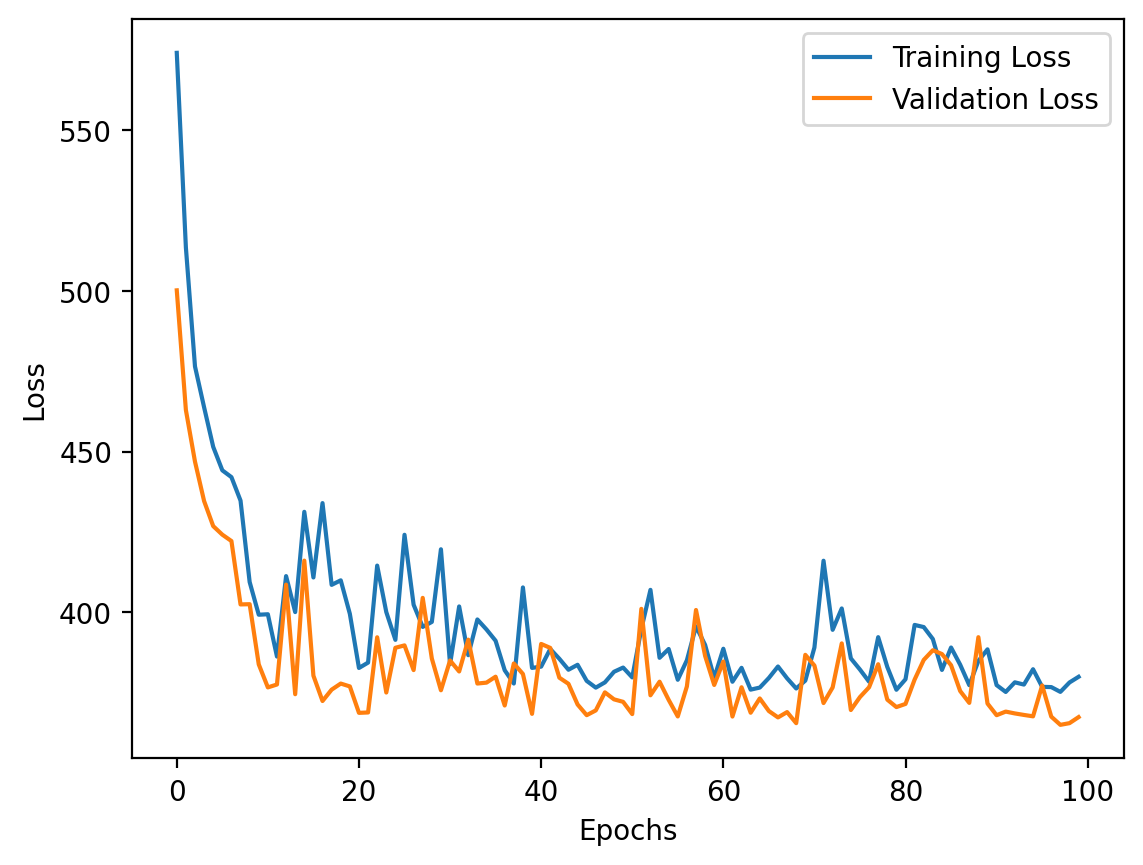

	 Training: ZINB
Begin the pretraining...
Average loss:  2.4731245522403715
Calculating reconstructions...
Calculating hidden representation...
[[3.0427015e-01 1.0505240e+00 1.2365659e+00 ... 6.9910321e+00
  4.7197051e+00 6.0853887e+00]
 [1.0753372e-01 9.5352381e-01 8.0178523e-01 ... 1.0389447e+01
  7.6028099e+00 7.7962651e+00]
 [2.1044046e-04 1.3174512e-03 1.3095952e-03 ... 1.3701624e-02
  1.0003756e-02 1.0506255e-02]
 [3.1212881e-02 1.5741558e-01 1.0143970e-01 ... 1.5501283e+00
  1.1754593e+00 1.1575674e+00]]


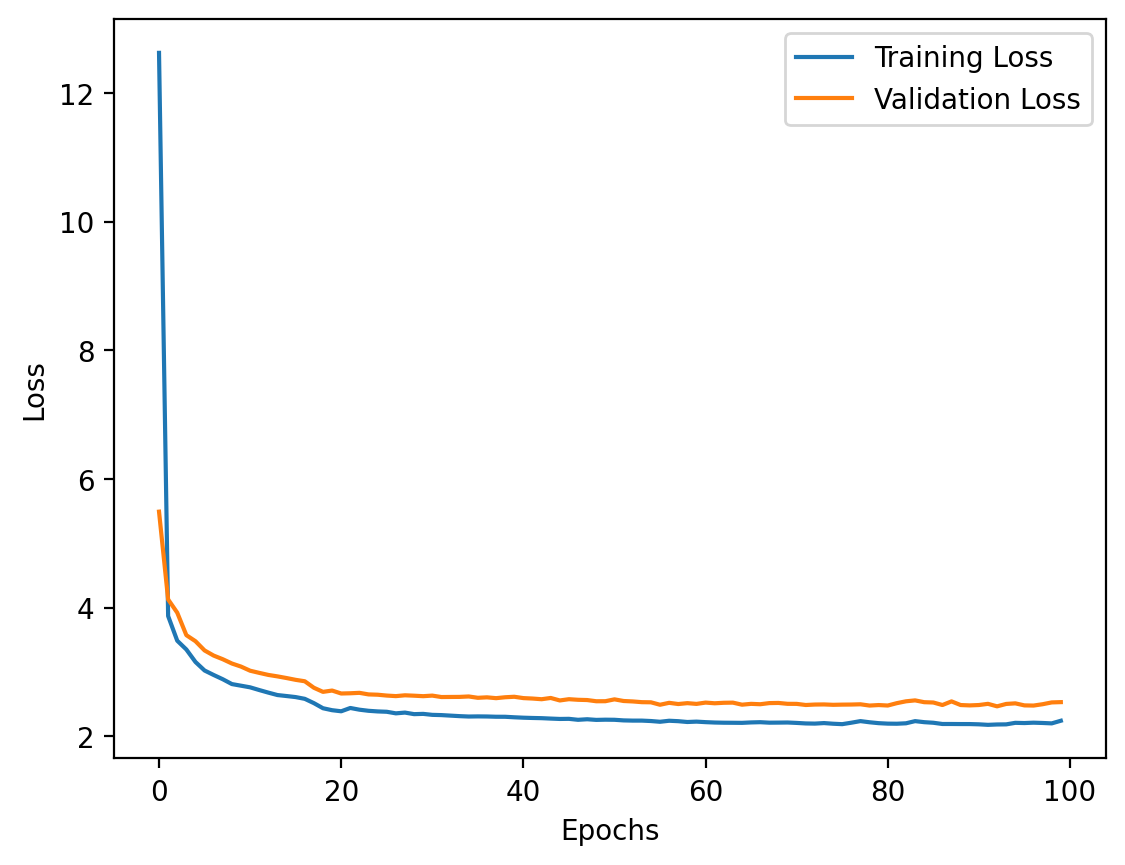

Processing: endoderm
Successfully preprocessed 1018 genes and 10000 cells
Selected 1018 genes and 10000 cells
	 Training: multinomial
Begin the pretraining...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Average loss:  620.1807593444823
Calculating reconstructions...
Calculating hidden representation...
[[9.69973145e+01 9.69973145e+01 9.69973145e+01 ... 6.95357361e+01
  7.00602341e+01 2.59037304e+01]
 [1.01062991e-01 1.01063274e-01 1.01062819e-01 ... 1.19828129e+01
  6.66048479e+00 7.74643373e+00]
 [1.92967907e-01 1.92968026e-01 1.92238525e-01 ... 1.08869362e+02
  8.73249741e+01 5.35694885e+01]
 [5.88828266e-01 5.88832557e-01 5.29619634e-01 ... 1.32919968e+02
  8.87255249e+01 8.23959122e+01]]


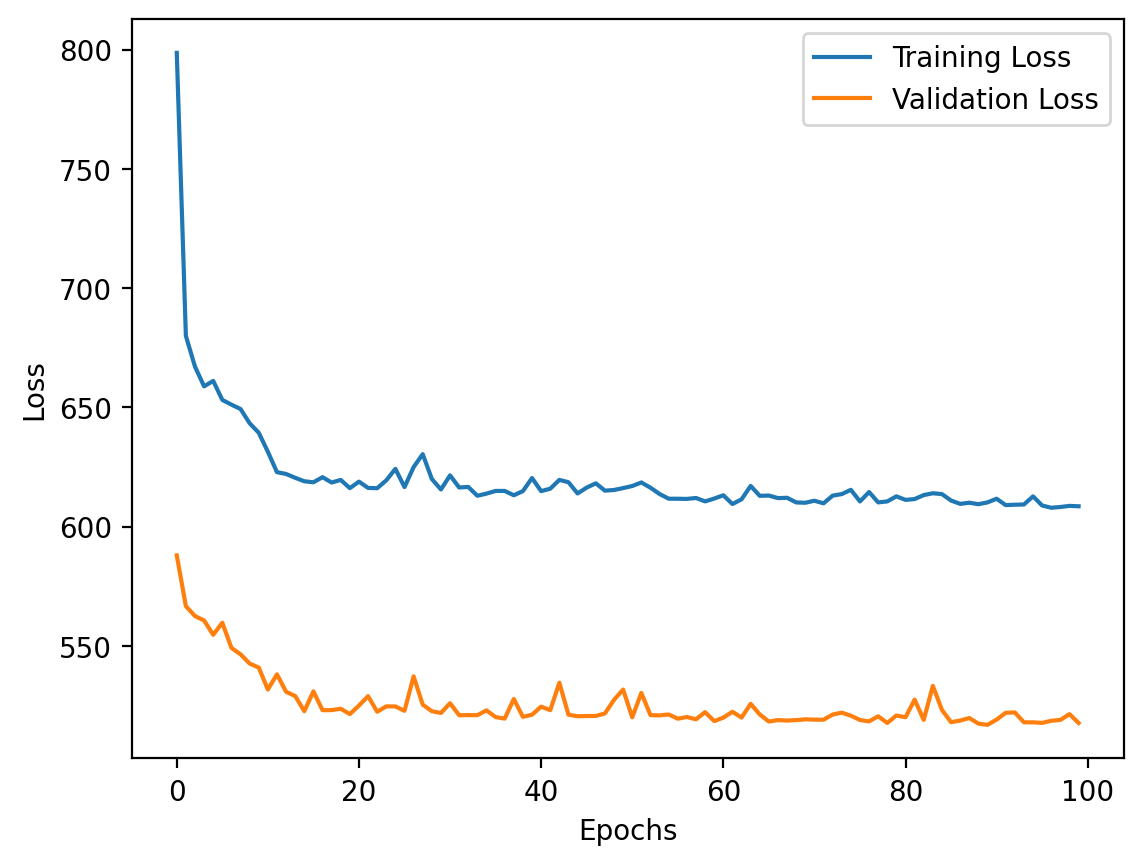

	 Training: ZINB
Begin the pretraining...
Average loss:  2.9688258353042607
Calculating reconstructions...
Calculating hidden representation...
[[7.07681580e+01 8.84302521e+01 7.96469727e+01 ... 8.99097534e+02
  1.13082751e+03 6.12158386e+02]
 [1.72001168e-01 3.74844313e-01 4.77057308e-01 ... 4.70030785e+00
  6.22560310e+00 3.89932466e+00]
 [4.25562143e+00 1.66326065e+01 1.39164362e+01 ... 5.79822769e+01
  7.59334259e+01 3.74784470e+01]
 [4.44089937e+00 1.59255085e+01 1.18054800e+01 ... 3.52797318e+01
  4.64908333e+01 2.64829140e+01]]


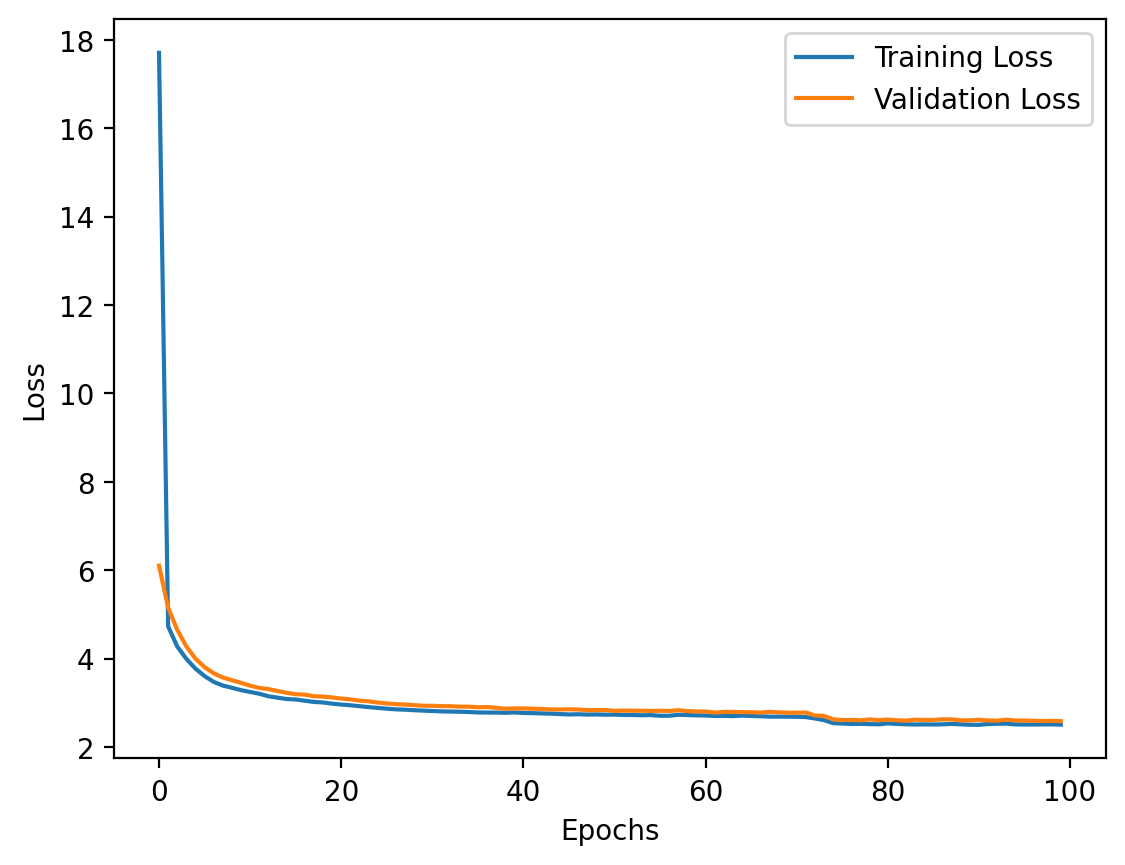

In [17]:
dataname = 'endoderm'
    # 'Quake_10x_Bladder','Quake_10x_Limb_Muscle', 'Quake_10x_Spleen',
    # 'group10_dropout1', 'group10_dropout5'

methods = ['multinomial','ZINB']#, 'weight mse', 'mask mse']
num_genes = [500, 1000, 5000, 10000]

for n_genes in num_genes[2:]:
    print('Processing: %s' % dataname)
    # data_path = dataname + '/data.h5'
    data_path = dataname + '/endoderm-%s.csv' % n_genes
    output_dir = 'results/' + dataname + '-%s' % n_genes
    os.makedirs(output_dir, exist_ok=True)
    
    data = prepro(data_path, transpose=True)
    data = normalize(data)

    input_size = data.n_vars
    output_size = input_size
    size_factor = np.array(data.obs.size_factors).reshape(-1, 1).astype(np.float32)

    for m in methods:
        
        adata = data.copy()
        print('\t Training: %s' % m)
        model = scDMFK(input_size=input_size, output_size=output_size,
                    dims=[64,32,64], learning_rate=0.001, distribution=m)
        model.pretrain(adata, size_factor, batch_size=64, pretrain_epoch=100)
        model.predict(adata)
        print(adata.X[:4,:]) # preview denoised data
        model.write(adata, output_dir=output_dir)
        model.print_train_history(output_dir=output_dir, save=True)

## simulated data

In [76]:
# load simulated data
dataname = 'group10_dropout1/counts.tsv'
output_dir = 'group10_dropout1'
transpose = True
sim1 = prepro(dataname, transpose)
sim1 = normalize(sim1)

input_size = sim1.n_vars
output_size = input_size
size_factor = np.array(sim1.obs.size_factors).reshape(-1, 1).astype(np.float32)

Successfully preprocessed 200 genes and 2000 cells


In [77]:
zinb = scDMFK(
    output_dir='results/group10_dropout1',input_size=input_size, output_size=output_size, distribution='ZINB')
zinb.pretrain(sim1, size_factor, batch_size=128, pretrain_epoch=100, gpu_option='0')
zinb.predict(sim1)

Creating new scDMFK model
Begin the pretraining...
Train on 1800 samples, validate on 200 samples
Epoch 1/100


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1800/1800 - 2s - loss: 1342.4121 - val_loss: 1120.8456
Epoch 2/100
1800/1800 - 0s - loss: 891.6831 - val_loss: 724.2812
Epoch 3/100
1800/1800 - 0s - loss: 558.7489 - val_loss: 492.4817
Epoch 4/100
1800/1800 - 0s - loss: 371.2765 - val_loss: 361.1945
Epoch 5/100
1800/1800 - 0s - loss: 259.9039 - val_loss: 286.8418
Epoch 6/100
1800/1800 - 0s - loss: 201.1879 - val_loss: 239.1531
Epoch 7/100
1800/1800 - 0s - loss: 160.0239 - val_loss: 205.5436
Epoch 8/100
1800/1800 - 0s - loss: 134.7058 - val_loss: 183.8565
Epoch 9/100
1800/1800 - 0s - loss: 114.1966 - val_loss: 167.1578
Epoch 10/100
1800/1800 - 0s - loss: 103.1936 - val_loss: 155.8759
Epoch 11/100
1800/1800 - 0s - loss: 92.3600 - val_loss: 145.9250
Epoch 12/100
1800/1800 - 0s - loss: 85.6244 - val_loss: 138.2565
Epoch 13/100
1800/1800 - 0s - loss: 80.1314 - val_loss: 130.8898
Epoch 14/100
1800/1800 - 0s - loss: 74.5095 - val_loss: 124.1965
Epoch 15/100
1800/1800 - 0s - loss: 70.0309 - val_loss: 118.1656
Epoch 16/100
1800/1800 - 0s - loss

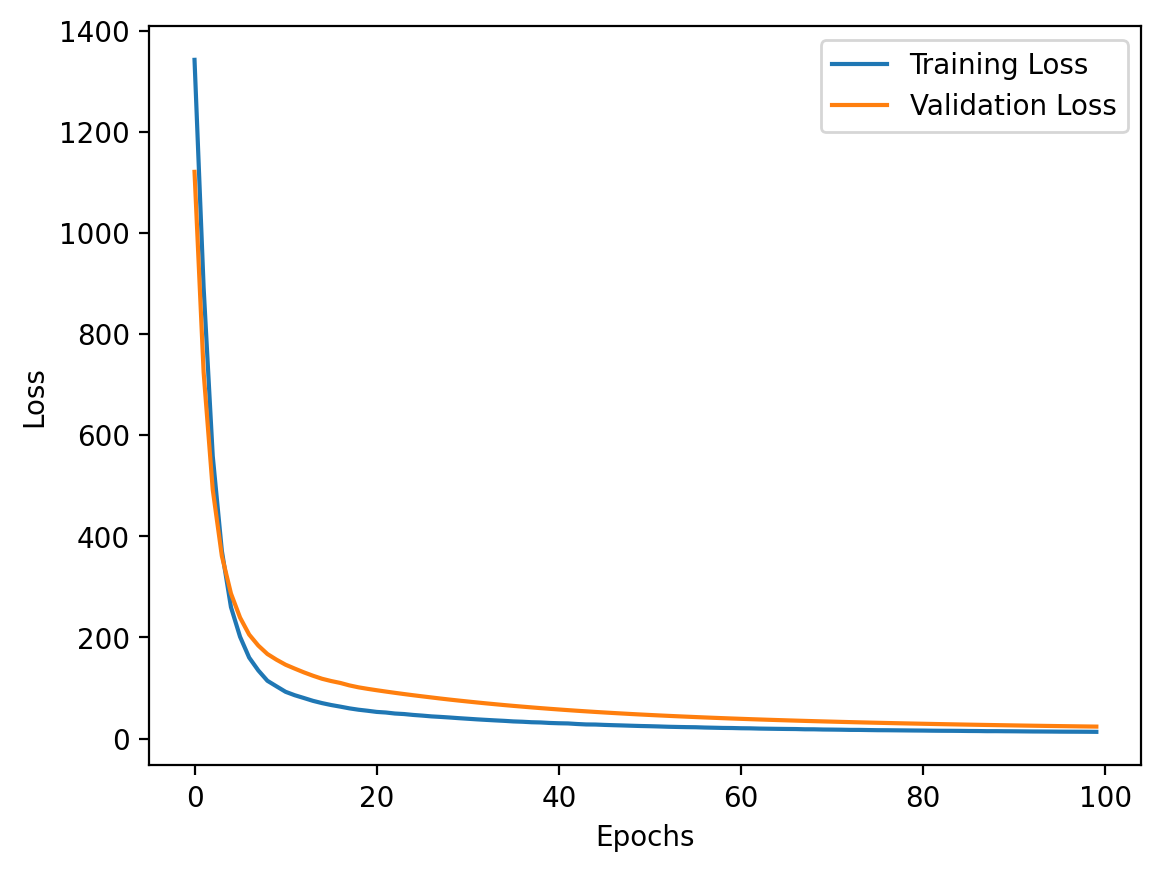

In [78]:
# zinb.print_train_history()

In [52]:
pd.DataFrame(sim1.X)

,0,1,2,3,4,5,6,7,8,9,...,189,190,191,192,193,194,195,196,197,198
0,9.236932,3.440368,5.749671,4.693779,10.372546,9.487016,18.334890,6.435522,19.473495,4.651821,...,11.313213,10.288234,18.818604,0.731434,4.912336,8.223145,6.839350,3.813099,2.614857,19.614655
1,5.468112,1.659218,3.814730,3.123067,6.150363,5.535604,11.165462,3.850573,11.744717,2.364002,...,6.404989,5.665302,10.983428,0.380163,2.657233,5.144146,3.698523,2.296307,1.142841,11.505073
2,7.295410,1.816989,4.322442,4.020203,7.281742,6.482594,13.258918,5.461424,13.888680,3.555041,...,9.288069,6.950316,13.932354,0.818072,3.255731,4.851985,5.166821,3.240341,1.683980,14.528437
3,9.836879,3.099688,5.209629,5.750198,8.452984,8.319779,16.666119,6.418504,18.346125,4.834490,...,11.168957,9.024836,17.124622,0.775758,3.377939,6.577843,6.331394,4.195677,2.230436,17.661205
4,5.059892,1.832766,3.528431,2.986511,5.893047,4.996325,9.742074,3.326699,10.894565,2.609836,...,5.837976,4.920083,9.305100,0.610524,2.773126,4.738744,2.822573,2.305315,0.909971,10.123084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,6.892665,1.845169,3.665350,3.379329,6.466769,5.553259,11.551841,4.513813,11.713070,3.495683,...,7.249651,6.007827,12.279042,0.411538,2.633348,5.368037,3.818506,2.683436,0.940354,12.364549
1996,7.869935,2.285827,4.207164,4.049319,7.751706,7.328610,15.405819,5.593473,14.801655,3.881312,...,10.039421,7.714956,14.579480,0.690606,2.915977,5.116651,5.936278,3.369304,2.040024,16.072769
1997,7.759191,2.166119,4.611842,4.240905,7.398804,7.194386,14.618117,5.335168,16.150393,3.565362,...,10.096045,7.815308,15.171632,0.638898,3.099386,5.971940,5.785883,3.516334,1.718967,15.417109
1998,7.730979,2.213163,3.973110,3.936977,6.776206,6.595955,13.009446,4.425412,14.870975,3.253459,...,8.454635,6.664238,13.205751,0.380610,2.163002,5.570274,4.670903,3.190904,1.363661,14.522338


In [56]:
sim1_label= pd.read_csv('data/group10_dropout1/info_cellinfo.tsv', sep='\t')['Group']
sim1_raw = pd.read_csv('data/group10_dropout1/counts.tsv', sep='\t')# raw data
# raw clustering
sim1_emb = get_embedding(sim1_raw.values)
draw_umap(sim1_emb, sim_label)

,Cell1,Cell2,Cell3,Cell4,Cell5,Cell6,Cell7,Cell8,Cell9,Cell10,...,Cell1991,Cell1992,Cell1993,Cell1994,Cell1995,Cell1996,Cell1997,Cell1998,Cell1999,Cell2000
Gene1,34,43,38,21,30,13,0,10,20,22,...,13,36,0,32,17,12,25,23,36,29
Gene2,98,65,60,56,57,0,79,28,56,65,...,51,67,41,120,38,38,71,59,51,0
Gene3,27,13,5,0,0,15,21,16,12,5,...,3,0,19,0,11,0,27,0,10,3
Gene4,496,312,312,406,254,373,220,154,283,374,...,244,339,306,435,350,278,299,291,310,258
Gene5,33,17,0,16,21,28,5,9,25,0,...,18,16,0,22,0,0,27,24,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gene196,160,160,126,144,105,82,101,0,87,122,...,66,100,109,142,120,67,105,90,77,79
Gene197,383,449,590,436,347,397,428,220,251,449,...,299,402,294,527,382,201,245,322,282,321
Gene198,1262,1416,1547,1279,1030,978,1222,566,990,1356,...,1132,1100,1057,0,784,982,1230,994,1075,935
Gene199,14,0,5,7,7,4,3,0,6,17,...,0,5,0,11,0,0,0,6,0,10


## UMAP Clustering: Endoderm data

In [11]:
from scDMFK.io import get_embedding, draw_umap
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def calculate_cluster_results(data, true_labels, seed):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    
    n_clusters = len(np.unique(true_labels))
    np.random.seed(seed)
    
    # get UMAP 2-D embedding
    embedding = get_embedding(data)
    draw_umap(embedding, true_labels)
    
    # K-means for clustering umi embedings
    kmeans = KMeans(n_clusters=n_clusters).fit(embedding)
    labels = kmeans.labels_

    # Calculate metrics
    ari = adjusted_rand_score(true_labels, labels)
    nmi = normalized_mutual_info_score(true_labels, labels)
    sc = silhouette_score(embedding, labels)

    print(f'Adjusted Rand Index: {ari}')
    print(f'Normalized Mutual Information: {nmi}')
    print(f'Silhouette Coefficient: {sc}')
    
    return ari, nmi, sc

In [49]:
## Let's rerun the model with the best model setting from previous hyperparam search:
# load endoderm data
dataname = "endoderm/endoderm.csv"
output_dir = None
transpose = True
highly_genes = None
highly_subset=False
adata = prepro(dataname, transpose=transpose)

adata = normalize(adata, highly_genes=highly_genes, highly_subset=highly_subset)
high_variable = adata.var.highly_variable

input_size = adata.n_vars
output_size = input_size
size_factor = np.array(adata.obs.size_factors).reshape(-1, 1).astype(np.float32)

best_model = scDMFK(input_size, output_size, dims=[64,32,64], learning_rate=0.001)
best_model.pretrain(adata, size_factor, batch_size=64, pretrain_epoch=100)
best_model.predict(adata)
# # model.write(adata)
endoderm_scdm = pd.DataFrame(adata.X, 
                    index=adata.obs_names,
                    columns=adata.var_names) #* adata.raw.X.sum(1)[:,np.newaxis]
endoderm_scdm

Successfully preprocessed 19097 genes and 1018 cells
Begin the pretraining...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Average loss:  2120.6221044681934
Calculating reconstructions...
Calculating hidden representation...


,MKL2,CD109,ABTB1,MAST2,KAT5,WWC2,CD163,UBE2Z,RGPD4,PHYHIPL,...,SNRNP48,ARMC3,DUSP28,INO80,NUP205,WDR33,EPSTI1,CLPTM1L,CCDC125,CATSPER3
H1_Exp1.001,25.868992,24.628611,0.500580,3.711763,25.867853,148.303802,0.041647,50.696587,25.867226,0.538591,...,25.869211,0.174745,0.538463,34.370800,284.121582,161.133484,0.580846,25.866959,25.869074,1.587115
H1_Exp1.002,39.537540,34.038826,0.820183,6.621381,39.536236,230.332581,0.088979,82.423309,39.534931,0.832700,...,39.537823,0.062845,1.746665,50.707733,386.723450,245.593658,0.863162,39.535053,39.537663,2.076407
H1_Exp1.003,31.136253,38.331810,0.576892,4.930996,31.135077,176.696991,0.063124,60.847084,31.134476,0.736968,...,31.136515,0.078192,0.943870,35.077103,310.881439,164.029297,0.510346,31.134130,31.136398,1.920202
H1_Exp1.004,24.128023,22.504652,0.525999,3.650322,24.127234,158.476013,0.023057,53.492165,24.126539,0.779788,...,24.128239,0.061555,1.184625,31.878557,263.441376,148.408600,0.443640,24.126539,24.128132,2.093164
H1_Exp1.006,20.576384,23.964817,0.407541,3.290749,20.575327,130.000214,0.052021,53.104057,20.574680,0.408695,...,20.576605,0.072777,0.785445,33.396225,257.100372,161.937500,0.456149,20.574577,20.576477,1.245227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TB_Batch2.140,0.710271,756.385681,0.032660,0.355514,0.703037,464.694092,0.017956,240.483719,0.709099,0.050044,...,0.711214,0.001860,0.025081,164.125046,874.674744,628.248840,0.265208,0.702536,0.710561,0.207562
TB_Batch2.141,0.609341,573.840149,0.138675,0.246449,0.601854,452.363037,0.035112,224.143631,0.601455,0.062944,...,0.612789,0.013512,0.105089,264.975189,1627.703125,501.819550,0.211799,0.599044,0.610502,0.149327
TB_Batch2.142,0.767183,1546.455078,0.115385,0.473100,0.754761,554.948975,0.008400,694.652649,0.759682,0.013068,...,0.770721,0.012357,0.166222,330.646484,432.857910,1149.007202,0.365852,0.752224,0.770877,0.102867
TB_Batch2.143,1.285179,1360.060669,0.183024,0.559966,1.273408,446.522888,0.026447,325.945892,1.280679,0.073259,...,1.287567,0.013814,0.157414,354.323517,1624.397949,678.177795,0.616541,1.271631,1.286250,0.375606


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


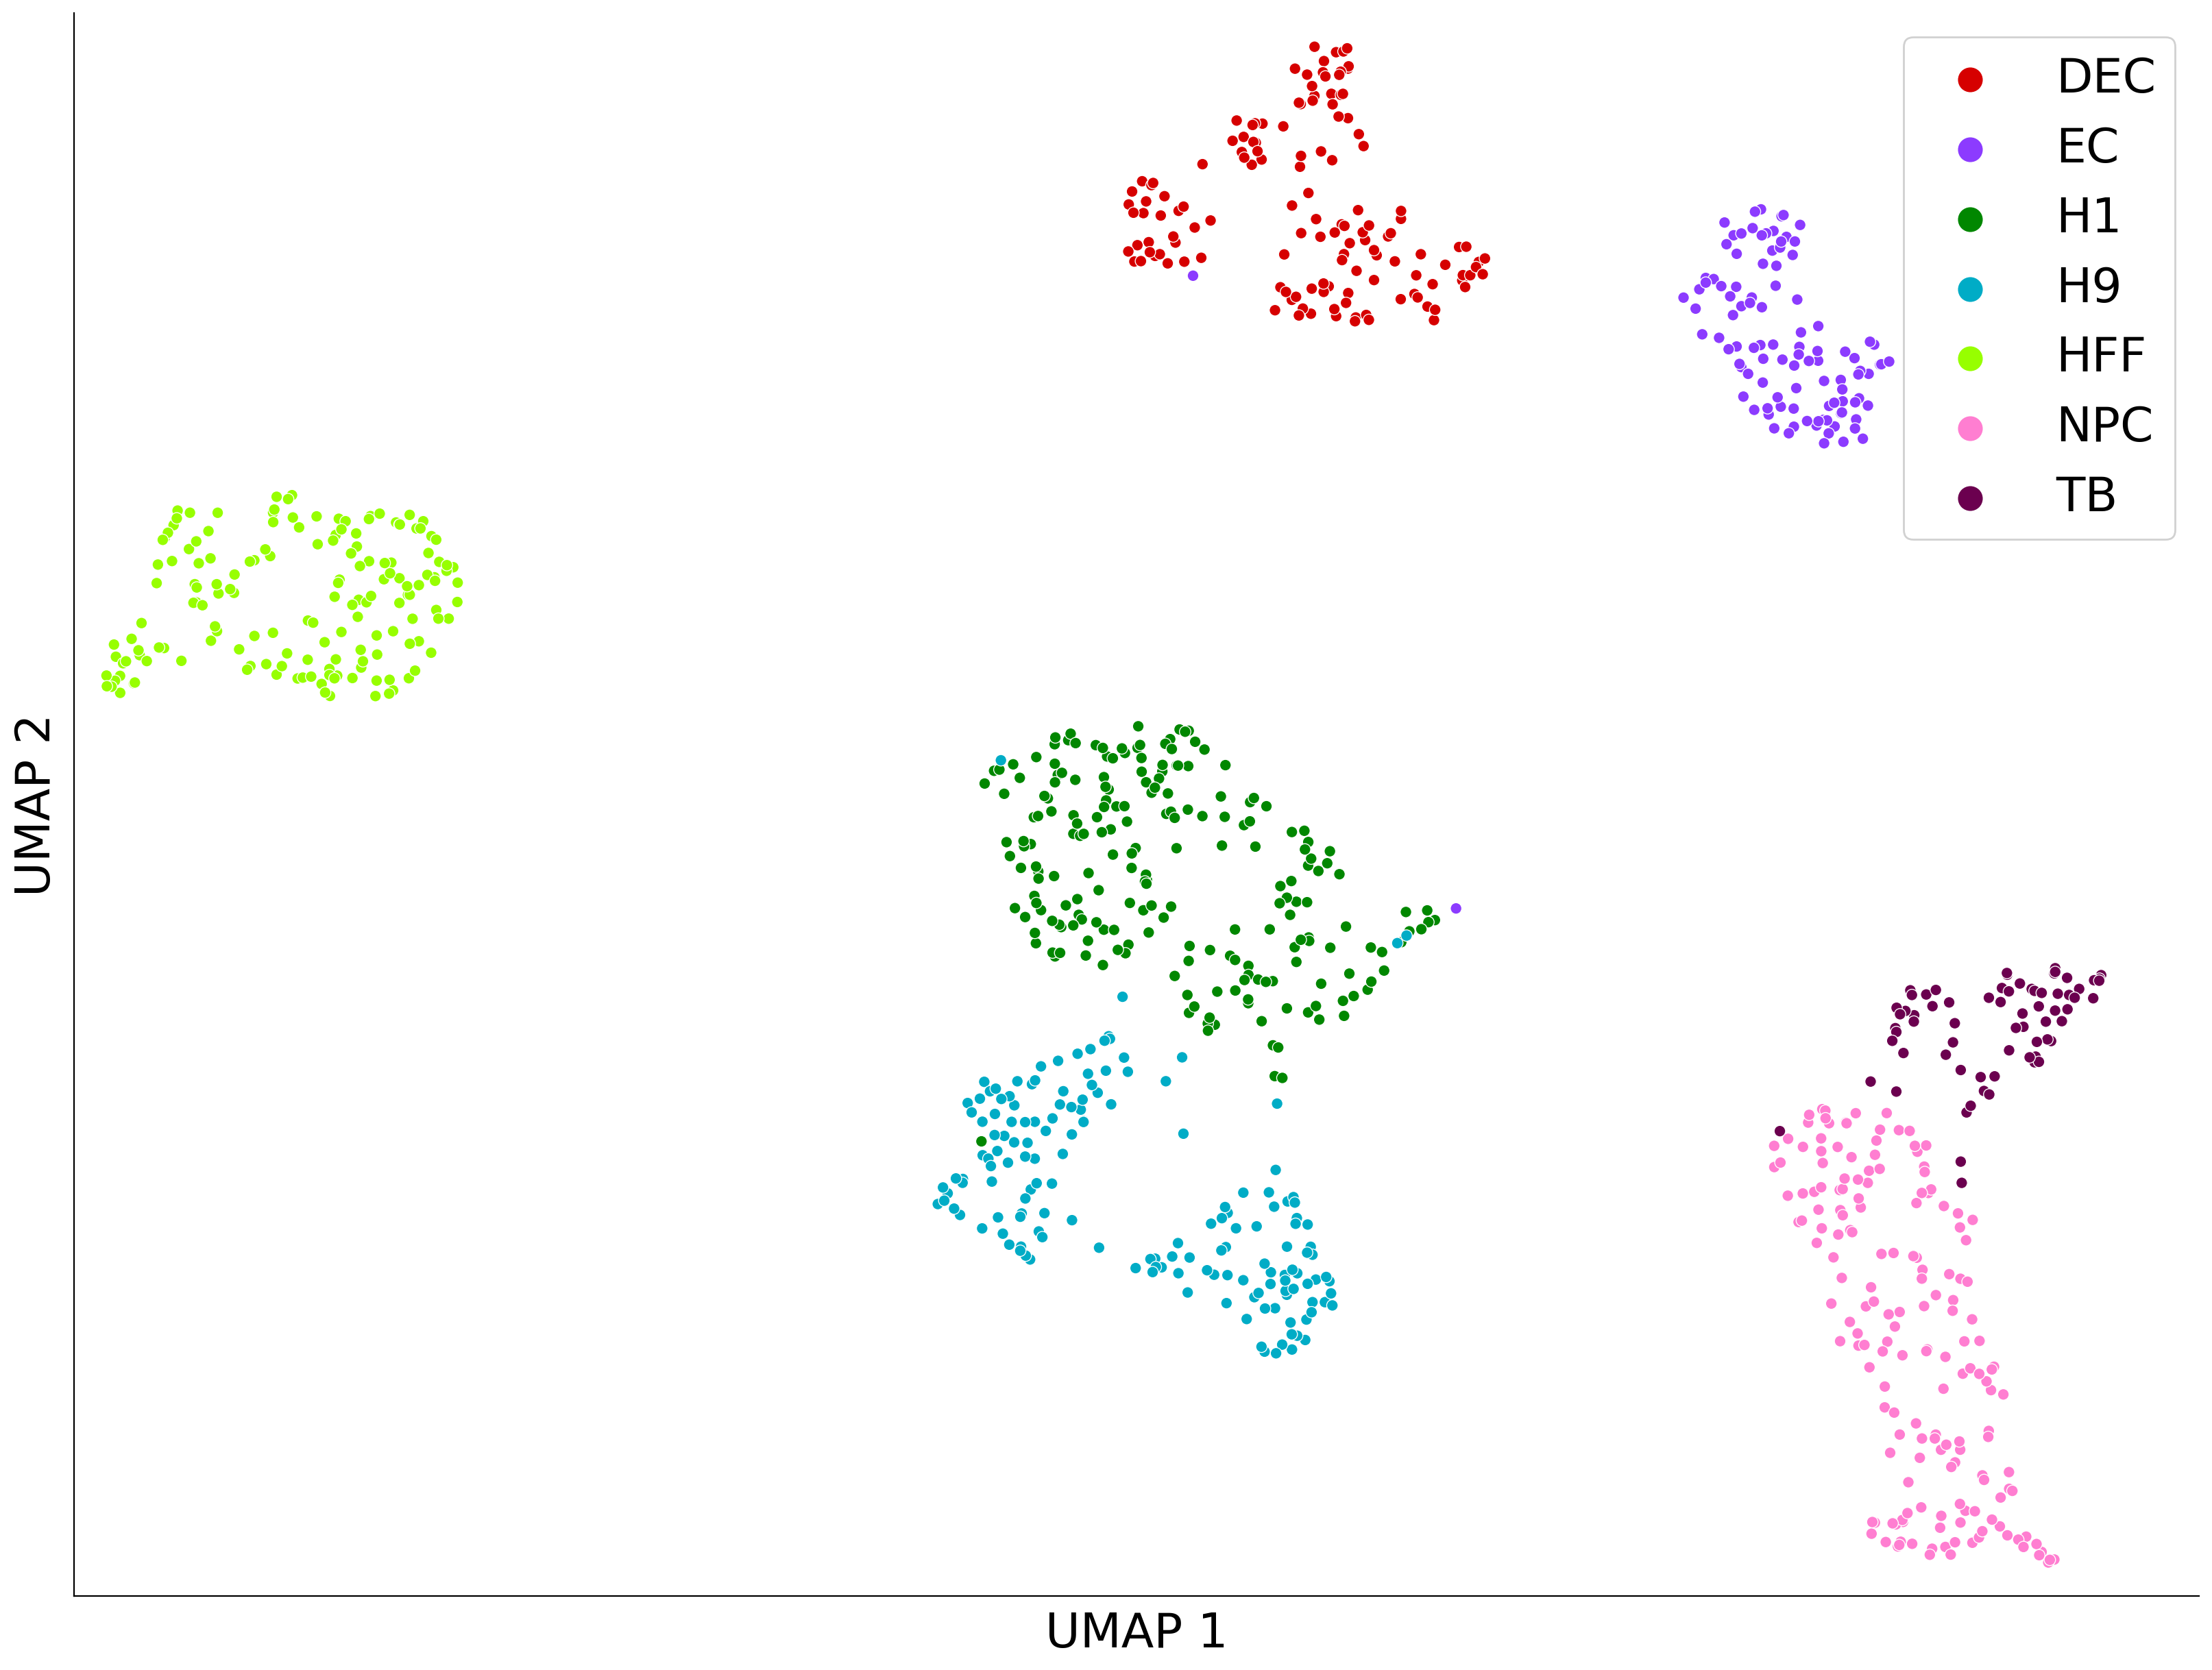

Adjusted Rand Index: 0.8882508768926031
Normalized Mutual Information: 0.9217947501727982
Silhouette Coefficient: 0.6144356727600098


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(0.8882508768926031, 0.9217947501727982, 0.6144357)

In [50]:
random_seed = [1111,22222,3333,4444,5555,6666,7777,8888,9999]
end_label = [label.split("_")[0] for label in endoderm_scdm.index.to_list()]
calculate_cluster_results(endoderm_scdm.loc[:,adata.var.highly_variable], end_label, 1111)

In [2]:
# DCA prediction
# endoderm_dca = pd.read_csv('data/endoderm/mean.tsv', sep='\t', index_col=0)
# endoderm_dca.T

# endoderm = pd.DataFrame(adata.raw.X, index=adata.obs_names, columns=adata.raw.var_names)[adata.var_names]
# endoderm

## Hyperparameter Search
Searching for optimal learning rate and epoch size and batch size

In [40]:
# load endoderm data
dataname = "endoderm/endoderm.csv"
output_dir = None
transpose = True
highly_genes = None
highly_subset=False
adata = prepro(dataname, transpose=transpose)

adata = normalize(adata, highly_genes=highly_genes, highly_subset=highly_subset)
data_label = [label.split("_")[0] for label in adata.obs_names.to_list()]
high_variable = adata.var.highly_variable
input_size = adata.n_vars
output_size = input_size
size_factor = np.array(adata.obs.size_factors).reshape(-1, 1).astype(np.float32)

learning_rate = [0.0001, 0.001]
batch_size=[256, 128, 64]
pretrain_epoch = [300, 100, 50]

hyper_result= []
for lr in learning_rate:
    for bs in batch_size:
        for epoch in pretrain_epoch:
            if not (lr==0.0001 and bs==256 and epoch==300):
                endoderm = adata.copy()
                # train model
                model = scDMFK(output_dir, input_size, output_size, dims=[64,32,64], learning_rate=lr)
                model.pretrain(endoderm, size_factor, batch_size=bs, pretrain_epoch=epoch, tensorboard=True)
                model.predict(endoderm)
            for mode in ['denoise', 'latent']:
                data = endoderm.X if mode=='denoise' else endoderm.obsm['X_hidden']
                # clustering metrics: all denoised genes
                ari, nmi, sc = calculate_cluster_results(data, data_label, 1111)
                # # only highly_variable genes
                # calculate_cluster_results(endoderm_scdm.loc[:,adata.var.highly_variable], end_label, 1111)
                hyper_result.append([lr, bs, epoch, mode, ari, nmi, sc])
                print(ari, nmi, sc)
pd.DataFrame(hyper_result, columns=['learning rate', 'batch size', 'epochs', 'mode', 'ARI','NMI','SC'])

/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.6410004795273216
Normalized Mutual Information: 0.7667294249635506
Silhouette Coefficient: 0.5789353847503662
0.6410004795273216 0.7667294249635506 0.5789354


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.5681495407474076
Normalized Mutual Information: 0.698629763361789
Silhouette Coefficient: 0.5250184535980225
0.5681495407474076 0.698629763361789 0.52501845
Begin the pretraining...


2024-04-21 14:49:27.076387: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 14:49:27.076660: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 14:49:27.364838: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 14:49:27.372637: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 14:49:27.384878: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/256100/plugins/profile/2024_04_21_14_49_27
2024-04-21 14:49:27.387098: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/256100/plugins/profile/2024_04_21_14_49_27/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 14:49:27.403255: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/256100/plugins/profile/2024_04_21_14_49_2

Average loss:  2324.5119193922037
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.576790854166142
Normalized Mutual Information: 0.7105014220735482
Silhouette Coefficient: 0.47957703471183777
0.576790854166142 0.7105014220735482 0.47957703


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.4385729779664899
Normalized Mutual Information: 0.5976884004903503
Silhouette Coefficient: 0.48690080642700195
0.4385729779664899 0.5976884004903503 0.4869008
Begin the pretraining...


2024-04-21 14:51:58.065706: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 14:51:58.065749: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 14:51:58.324246: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 14:51:58.327740: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 14:51:58.332737: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/25650/plugins/profile/2024_04_21_14_51_58
2024-04-21 14:51:58.334232: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/25650/plugins/profile/2024_04_21_14_51_58/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 14:51:58.338528: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/25650/plugins/profile/2024_04_21_14_51_58
2

Average loss:  2481.160376090535
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.5926662860418853
Normalized Mutual Information: 0.7148029869094447
Silhouette Coefficient: 0.5347402095794678
0.5926662860418853 0.7148029869094447 0.5347402


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.38496558077636966
Normalized Mutual Information: 0.5143305444413503
Silhouette Coefficient: 0.4650227129459381
0.38496558077636966 0.5143305444413503 0.4650227
Begin the pretraining...


2024-04-21 14:53:39.933866: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 14:53:39.933917: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 14:53:40.075899: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 14:53:40.077764: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 14:53:40.081553: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/128300/plugins/profile/2024_04_21_14_53_40
2024-04-21 14:53:40.082651: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/128300/plugins/profile/2024_04_21_14_53_40/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 14:53:40.086397: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/128300/plugins/profile/2024_04_21_14_53_4

Average loss:  2147.067743899683
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.6310847313516496
Normalized Mutual Information: 0.7787754579661536
Silhouette Coefficient: 0.5689557790756226
0.6310847313516496 0.7787754579661536 0.5689558


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.622812967836742
Normalized Mutual Information: 0.747638922091121
Silhouette Coefficient: 0.5302939414978027
0.622812967836742 0.747638922091121 0.53029394
Begin the pretraining...


2024-04-21 14:59:21.291154: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 14:59:21.291196: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 14:59:21.431715: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 14:59:21.434212: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 14:59:21.436768: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/128100/plugins/profile/2024_04_21_14_59_21
2024-04-21 14:59:21.437837: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/128100/plugins/profile/2024_04_21_14_59_21/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 14:59:21.440891: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/128100/plugins/profile/2024_04_21_14_59_2

Average loss:  2250.6569020984093
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.6332401659645928
Normalized Mutual Information: 0.7596578857528902
Silhouette Coefficient: 0.5933480858802795
0.6332401659645928 0.7596578857528902 0.5933481


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.5437581908046513
Normalized Mutual Information: 0.6971037858833464
Silhouette Coefficient: 0.5308065414428711
0.5437581908046513 0.6971037858833464 0.53080654
Begin the pretraining...


2024-04-21 15:01:49.501329: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:01:49.501372: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:01:49.616806: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:01:49.621582: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:01:49.624339: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/12850/plugins/profile/2024_04_21_15_01_49
2024-04-21 15:01:49.625718: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/12850/plugins/profile/2024_04_21_15_01_49/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:01:49.629473: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/12850/plugins/profile/2024_04_21_15_01_49
2

Average loss:  2364.502002834911
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.6171318472859969
Normalized Mutual Information: 0.7428277120522758
Silhouette Coefficient: 0.5069876313209534
0.6171318472859969 0.7428277120522758 0.50698763


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.5338992516324088
Normalized Mutual Information: 0.6740233228210156
Silhouette Coefficient: 0.5078646540641785
0.5338992516324088 0.6740233228210156 0.50786465
Begin the pretraining...


2024-04-21 15:03:37.568559: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:03:37.568785: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:03:37.634935: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:03:37.636990: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:03:37.640799: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/64300/plugins/profile/2024_04_21_15_03_37
2024-04-21 15:03:37.641677: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/64300/plugins/profile/2024_04_21_15_03_37/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:03:37.645185: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/64300/plugins/profile/2024_04_21_15_03_37
2

Average loss:  2122.9991733410434
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.7184252797064878
Normalized Mutual Information: 0.840844291982022
Silhouette Coefficient: 0.5737687349319458
0.7184252797064878 0.840844291982022 0.57376873


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.6392537841810095
Normalized Mutual Information: 0.7812611357851401
Silhouette Coefficient: 0.5519044995307922
0.6392537841810095 0.7812611357851401 0.5519045
Begin the pretraining...


2024-04-21 15:17:58.918788: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:17:58.918946: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:17:59.002241: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:17:59.004798: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:17:59.007608: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/64100/plugins/profile/2024_04_21_15_17_59
2024-04-21 15:17:59.008960: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/64100/plugins/profile/2024_04_21_15_17_59/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:17:59.014203: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/64100/plugins/profile/2024_04_21_15_17_59
2

Average loss:  2204.046953556895
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.7144228123695315
Normalized Mutual Information: 0.8278661788769297
Silhouette Coefficient: 0.5918964147567749
0.7144228123695315 0.8278661788769297 0.5918964


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.7036262166474763
Normalized Mutual Information: 0.8042446498570335
Silhouette Coefficient: 0.548481822013855
0.7036262166474763 0.8042446498570335 0.5484818
Begin the pretraining...


2024-04-21 15:20:23.199672: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:20:23.199717: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:20:23.284901: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:20:23.286799: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:20:23.290624: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/6450/plugins/profile/2024_04_21_15_20_23
2024-04-21 15:20:23.291563: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/6450/plugins/profile/2024_04_21_15_20_23/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:20:23.295303: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/6450/plugins/profile/2024_04_21_15_20_23
2024

Average loss:  2278.116882060283
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.6366321594951498
Normalized Mutual Information: 0.7623548961539707
Silhouette Coefficient: 0.5375158786773682
0.6366321594951498 0.7623548961539707 0.5375159


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.560619471261183
Normalized Mutual Information: 0.685412077987174
Silhouette Coefficient: 0.4971766173839569
0.560619471261183 0.685412077987174 0.49717662
Begin the pretraining...


2024-04-21 15:22:01.528920: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:22:01.528963: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:22:01.743070: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:22:01.746236: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:22:01.749265: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/256300/plugins/profile/2024_04_21_15_22_01
2024-04-21 15:22:01.750197: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/256300/plugins/profile/2024_04_21_15_22_01/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:22:01.753541: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/256300/plugins/profile/2024_04_21_15_22_0

Average loss:  2092.2364429750687
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.7924626021346112
Normalized Mutual Information: 0.8866702493578268
Silhouette Coefficient: 0.682937502861023
0.7924626021346112 0.8866702493578268 0.6829375


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.6709080677394367
Normalized Mutual Information: 0.7650174764135613
Silhouette Coefficient: 0.5764737129211426
0.6709080677394367 0.7650174764135613 0.5764737
Begin the pretraining...


2024-04-21 15:27:37.286382: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:27:37.287287: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:27:37.697235: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:27:37.707430: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:27:37.714152: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/256100/plugins/profile/2024_04_21_15_27_37
2024-04-21 15:27:37.716282: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/256100/plugins/profile/2024_04_21_15_27_37/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:27:37.726991: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/256100/plugins/profile/2024_04_21_15_27_3

Average loss:  2154.7684361743222
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.7028785040453258
Normalized Mutual Information: 0.8335237505737657
Silhouette Coefficient: 0.6282875537872314
0.7028785040453258 0.8335237505737657 0.62828755


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.6294542036732935
Normalized Mutual Information: 0.7387372470909729
Silhouette Coefficient: 0.5421333312988281
0.6294542036732935 0.7387372470909729 0.54213333
Begin the pretraining...


2024-04-21 15:30:16.641941: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:30:16.641988: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:30:16.894503: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:30:16.898087: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:30:16.900421: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/25650/plugins/profile/2024_04_21_15_30_16
2024-04-21 15:30:16.901361: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/25650/plugins/profile/2024_04_21_15_30_16/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:30:16.906949: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/25650/plugins/profile/2024_04_21_15_30_16
2

Average loss:  2201.10665250811
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.723347855812337
Normalized Mutual Information: 0.8458460286967867
Silhouette Coefficient: 0.5871989130973816
0.723347855812337 0.8458460286967867 0.5871989


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.6104381422378334
Normalized Mutual Information: 0.7462530557239911
Silhouette Coefficient: 0.5938301086425781
0.6104381422378334 0.7462530557239911 0.5938301
Begin the pretraining...


2024-04-21 15:32:06.968984: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:32:06.969029: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:32:07.090307: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:32:07.092479: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:32:07.095251: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/128300/plugins/profile/2024_04_21_15_32_07
2024-04-21 15:32:07.096289: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/128300/plugins/profile/2024_04_21_15_32_07/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:32:07.100501: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/128300/plugins/profile/2024_04_21_15_32_0

Average loss:  2080.7249812365635
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.7234637417452651
Normalized Mutual Information: 0.8344046722703012
Silhouette Coefficient: 0.5984143614768982
0.7234637417452651 0.8344046722703012 0.59841436


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.6403378620263773
Normalized Mutual Information: 0.7649379877843395
Silhouette Coefficient: 0.5173547267913818
0.6403378620263773 0.7649379877843395 0.5173547
Begin the pretraining...


2024-04-21 15:38:00.380277: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:38:00.380349: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:38:00.508982: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:38:00.510925: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:38:00.513508: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/128100/plugins/profile/2024_04_21_15_38_00
2024-04-21 15:38:00.514742: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/128100/plugins/profile/2024_04_21_15_38_00/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:38:00.518933: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/128100/plugins/profile/2024_04_21_15_38_0

Average loss:  2125.8887725755094
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.6826861030904241
Normalized Mutual Information: 0.8207748711093006
Silhouette Coefficient: 0.6340242028236389
0.6826861030904241 0.8207748711093006 0.6340242


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.6567571478516354
Normalized Mutual Information: 0.7676338001704752
Silhouette Coefficient: 0.5330774784088135
0.6567571478516354 0.7676338001704752 0.5330775
Begin the pretraining...


2024-04-21 15:40:31.197378: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:40:31.197440: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:40:31.310767: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:40:31.312787: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:40:31.314624: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/12850/plugins/profile/2024_04_21_15_40_31
2024-04-21 15:40:31.315681: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/12850/plugins/profile/2024_04_21_15_40_31/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:40:31.318926: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/12850/plugins/profile/2024_04_21_15_40_31
2

Average loss:  2173.83243153865
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.6561189359230618
Normalized Mutual Information: 0.8158769623249146
Silhouette Coefficient: 0.6111984848976135
0.6561189359230618 0.8158769623249146 0.6111985


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.5888364452609487
Normalized Mutual Information: 0.7362779748326651
Silhouette Coefficient: 0.5432433485984802
0.5888364452609487 0.7362779748326651 0.54324335
Begin the pretraining...


2024-04-21 15:42:27.280309: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:42:27.281266: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:42:27.378622: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:42:27.380542: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:42:27.383240: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/64300/plugins/profile/2024_04_21_15_42_27
2024-04-21 15:42:27.384155: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/64300/plugins/profile/2024_04_21_15_42_27/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:42:27.388171: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/64300/plugins/profile/2024_04_21_15_42_27
2

Average loss:  2104.684213305324
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.7670263106458354
Normalized Mutual Information: 0.8671183054400738
Silhouette Coefficient: 0.6255797743797302
0.7670263106458354 0.8671183054400738 0.6255798


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.6821990852638848
Normalized Mutual Information: 0.7910867913533101
Silhouette Coefficient: 0.5717501044273376
0.6821990852638848 0.7910867913533101 0.5717501
Begin the pretraining...


2024-04-21 15:47:40.660009: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:47:40.660056: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:47:40.780608: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:47:40.782637: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:47:40.785087: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/64100/plugins/profile/2024_04_21_15_47_40
2024-04-21 15:47:40.786329: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/64100/plugins/profile/2024_04_21_15_47_40/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:47:40.789962: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/64100/plugins/profile/2024_04_21_15_47_40
2

Average loss:  2147.9831871478855
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.9406229948836696
Normalized Mutual Information: 0.9471687068707904
Silhouette Coefficient: 0.6219128370285034
0.9406229948836696 0.9471687068707904 0.62191284


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.5933360400435851
Normalized Mutual Information: 0.7287972556710064
Silhouette Coefficient: 0.5421868562698364
0.5933360400435851 0.7287972556710064 0.54218686
Begin the pretraining...


2024-04-21 15:50:14.759667: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:50:14.759713: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:50:14.835288: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:50:14.838686: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:50:14.843195: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/6450/plugins/profile/2024_04_21_15_50_14
2024-04-21 15:50:14.844120: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/6450/plugins/profile/2024_04_21_15_50_14/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:50:14.849516: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/6450/plugins/profile/2024_04_21_15_50_14
2024

Average loss:  2158.300345210045
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.7298129454388979
Normalized Mutual Information: 0.8372610201886169
Silhouette Coefficient: 0.6081847548484802
0.7298129454388979 0.8372610201886169 0.60818475
Adjusted Rand Index: 0.6429615276124758
Normalized Mutual Information: 0.7536973011961531
Silhouette Coefficient: 0.553936243057251
0.6429615276124758 0.7536973011961531 0.55393624


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,learning rate,batch size,epochs,mode,ARI,NMI,SC
0,0.0001,256,300,denoise,0.641000,0.766729,0.578935
1,0.0001,256,300,latent,0.568150,0.698630,0.525018
2,0.0001,256,100,denoise,0.576791,0.710501,0.479577
3,0.0001,256,100,latent,0.438573,0.597688,0.486901
4,0.0001,256,50,denoise,0.592666,0.714803,0.534740
5,0.0001,256,50,latent,0.384966,0.514331,0.465023
6,0.0001,128,300,denoise,0.631085,0.778775,0.568956
7,0.0001,128,300,latent,0.622813,0.747639,0.530294
8,0.0001,128,100,denoise,0.633240,0.759658,0.593348
9,0.0001,128,100,latent,0.543758,0.697104,0.530807


In [47]:
hyper_result = pd.DataFrame(hyper_result, columns=['learning rate', 'batch size', 'epochs', 'mode', 'ARI','NMI','SC'])
hyper_result.sort_values(by=['mode','learning rate'])
# hyper_result.to_csv('results/hyper-search.csv')

,learning rate,batch size,epochs,mode,ARI,NMI,SC
0,0.0001,256,300,denoise,0.641000,0.766729,0.578935
2,0.0001,256,100,denoise,0.576791,0.710501,0.479577
4,0.0001,256,50,denoise,0.592666,0.714803,0.534740
6,0.0001,128,300,denoise,0.631085,0.778775,0.568956
8,0.0001,128,100,denoise,0.633240,0.759658,0.593348
10,0.0001,128,50,denoise,0.617132,0.742828,0.506988
12,0.0001,64,300,denoise,0.718425,0.840844,0.573769
14,0.0001,64,100,denoise,0.714423,0.827866,0.591896
16,0.0001,64,50,denoise,0.636632,0.762355,0.537516
18,0.0010,256,300,denoise,0.792463,0.886670,0.682938
